In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
from src.ds import Dataset, collate_fn
from torch.utils.data import DataLoader
import time

Intentando acelerar el data loading...

In [5]:
train = pd.read_json('data/train.json')

In [6]:
ds = Dataset(
	train.filename.values, 
	(0, 1, 2),
	(2,1,0), 
	['September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August'], 
	train.label.values
)

In [7]:
# measure time to load data

results = []
num_batches = 100
# con 12 meses peta a partir de bs 16
for bs in [1, 2, 4, 8]: #, 16, 32, 64]:
	dl = DataLoader(ds, batch_size=bs, shuffle=True, num_workers=10, pin_memory=True, collate_fn=collate_fn)
	start = time.time()
	for i, batch in enumerate(dl):
		(s1, s2), y = batch
		s1, s2 = s1.cuda(), s2.cuda()
		# s1, s2 = s1.cuda(non_blocking=True), s2.cuda(non_blocking=True)
		if i == num_batches:
			break
	end = time.time()
	print(f'100 batches loaded in {end-start:.2f} seconds')
	results.append((bs, end-start))

100 batches loaded in 2.79 seconds
100 batches loaded in 3.18 seconds
100 batches loaded in 6.52 seconds
100 batches loaded in 21.63 seconds


In [8]:
import cupy as cp

class ExternalInputIterator(object):
    def __init__(self, chip_ids, batch_size):
        self.batch_size = batch_size
        self.chip_ids = chip_ids
        self.sensors = ['S1', 'S2']

    def __iter__(self):
        self.i = 0
        self.n = len(self.chip_ids)
        return self

    def __next__(self):
        batch1, batch2, labels = [], [], []
        for _ in range(self.batch_size):
            chip_id = self.chip_ids[self.i]
            x1 = cp.load(
                f'data/train_features_npy/{chip_id}_S1.npy')
            x2 = cp.load(
                f'data/train_features_npy/{chip_id}_S2.npy')
            batch1.append(x1)
            batch2.append(x2)
            labels.append(cp.load(f'data/train_agbm_npy/{chip_id}.npy'))
            self.i = (self.i + 1) % self.n
        return (batch1, batch2, labels)

    def __len__(self):
        return self.data_set_len

    next = __next__

In [9]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types

train = pd.read_csv('data/train_chip_ids.csv')
batch_size = 4
eii = ExternalInputIterator(
	train.chip_id.values, 
	batch_size
)

x1, x2, labels = next(iter(eii))

In [10]:
batch_size = 4
pipe = Pipeline(batch_size=batch_size, num_threads=2, device_id=0)
with pipe:
    x1, x2, labels = fn.external_source(source=eii, num_outputs=3, device="gpu", dtype=types.FLOAT)
    pipe.set_outputs(x1, x2, labels)

pipe.build()

In [11]:
pipe_out = pipe.run()
pipe_out

(TensorListGPU(
     [[[[[0.42642784 0.39542863 ... 0.37915483 0.35918882]
         [0.60205966 0.64275837 ... 0.5791946  0.60930747]
         [0.5142437  0.51909345 ... 0.4791747  0.4842481 ]]
 
        [[0.46515542 0.41169363 ... 0.35899642 0.3842773 ]
         [0.6599043  0.655473   ... 0.61280185 0.633426  ]
         [0.5625299  0.53358334 ... 0.48589912 0.50885165]]
 
        ...
 
        [[0.29797798 0.3334917  ... 0.36704504 0.38450578]
         [0.5564118  0.57787025 ... 0.5834187  0.56306887]
         [0.42719486 0.455681   ... 0.47523192 0.4737873 ]]
 
        [[0.30800146 0.33702204 ... 0.35814592 0.394589  ]
         [0.56191474 0.59604675 ... 0.59554213 0.5735994 ]
         [0.43495813 0.46653438 ... 0.47684404 0.48409417]]]
 
 
       [[[0.44248462 0.38069034 ... 0.40284598 0.3860075 ]
         [0.63242173 0.6191727  ... 0.6057118  0.6064507 ]
         [0.53745323 0.4999315  ... 0.50427884 0.49622908]]
 
        [[0.4735455  0.41218606 ... 0.3483236  0.39336514]
        

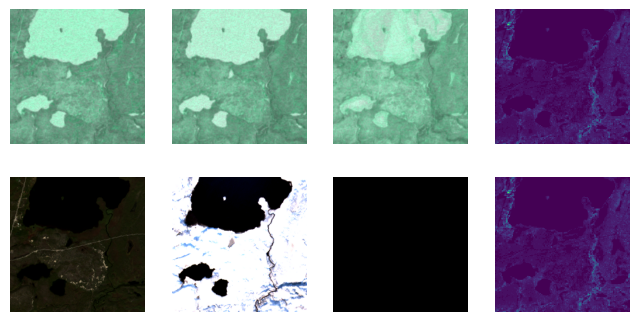

In [14]:
import matplotlib.pyplot as plt

s1s, s2s, labels = pipe_out
s1s, s2s, labels = s1s.as_cpu(), s2s.as_cpu(), labels.as_cpu()

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(2, 4, 1)
ix = 0
ax.imshow(s1s.at(ix)[...,0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 2)
ax.imshow(s1s.at(ix)[...,1])
ax.axis('off')
ax = fig.add_subplot(2, 4, 3)
ax.imshow(s1s.at(ix)[...,2])
ax.axis('off')
ax = fig.add_subplot(2, 4, 4)
ax.imshow(labels.at(ix))
ax.axis('off')
ax = fig.add_subplot(2, 4, 5)
ax.imshow(s2s.at(ix)[...,0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 6)
ax.imshow(s2s.at(ix)[...,1])
ax.axis('off')
ax = fig.add_subplot(2, 4, 7)
ax.imshow(s2s.at(ix)[...,2])
ax.axis('off')
ax = fig.add_subplot(2, 4, 8)
ax.imshow(labels.at(ix))
ax.axis('off')
plt.show()

In [15]:
from nvidia.dali.plugin.pytorch import DALIGenericIterator

results = []
num_batches = 100
for bs in [1, 2, 4, 8, 16, 32]:#, 64]:
	eii = ExternalInputIterator(
		train.chip_id.values, 
		batch_size=bs
	)
	pipe = Pipeline(batch_size=bs, num_threads=10, device_id=0)
	with pipe:
		x1, x2, labels = fn.external_source(source=eii, num_outputs=3, device="gpu", dtype=types.FLOAT)
		pipe.set_outputs(x1, x2, labels)
	pipe.build()
	pii = DALIGenericIterator([pipe], ['s1s', 's2s', 'labels'])
	start = time.time()
	for i, data in enumerate(pii):
		batch_data = data[0]
		s1s, s2s, labels = batch_data["s1s"], batch_data["s2s"], batch_data["labels"]
		if i == num_batches:
			print(s1s.shape, s1s.device)
			break
	end = time.time()
	print(f'100 batches loaded in {end-start:.2f} seconds')
	results.append((bs, end-start))

torch.Size([1, 256, 256, 3, 12]) cuda:0
100 batches loaded in 0.82 seconds
torch.Size([2, 256, 256, 3, 12]) cuda:0
100 batches loaded in 1.16 seconds
torch.Size([4, 256, 256, 3, 12]) cuda:0
100 batches loaded in 2.25 seconds
torch.Size([8, 256, 256, 3, 12]) cuda:0
100 batches loaded in 4.64 seconds
torch.Size([16, 256, 256, 3, 12]) cuda:0
100 batches loaded in 9.79 seconds
torch.Size([32, 256, 256, 3, 12]) cuda:0
100 batches loaded in 29.22 seconds


Inceríble speedup!